# 📖 Jupyter Notebook Tool 🔧

This tool will iterate through a notebook or several notebooks and will check them for:
 - Deny-list keywords
 - Hard-coded variables
 
The Notebook being checked will then be given a "grade" depending on the severity of the issues the tool has detected. If a Notebook passes a certain grade threshold, that Notebook will then be flagged so it can be checked by a central administrator.

## 💥Table of Contents💥
1. [Importing Libraries and Functions](#importfunctions) - Boring part. Loads in all the necessary functions and libraries.

2. [Papermill Injection](#papermill) - Parameters for the notebooks to be checked against are injected here.

3. [Load Notebooks](#loadnotebooks) - Function that loads all of notebooks ready for analysis.

4. [Notebook Analysis Function](#notebookfunction) - The guts and inner-workings of the tool.

6. [Detailed Report](#detailedreport) - A more in-depth line-by-line analysis of problems in the notebooks.

5. [Short Report](#shortreport) - If you just want to see the results quickly.

7. [Visual Report](#visualreport) - Graphical analysis easily see the worst offenders.


## Import Libraries and Functions <a id="importfunctions"></a>
The following code will import all of the libraries and functions we require for our tool to run.

In [1]:
#import required libraries:

# *** Should we import these inside functions mixed eview on practices as it is dire to program but if functiond pulled out ad implemented in other code will require this 
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import json
import codecs
import ast
from io import StringIO
from os import path
#import word and regex functions for checking 
from disallowTermCheck import checkTerms
from disallowRegexCheck import checkRegex
# from unit_testing_nonallowedwords import checkword

## Papermill Parameter Injection <a id="papermill"></a>
Here we will define the variables that need to be injected as parameters through Papermill. This can be done by using the bash script present in the directory or by manually typing the command in a CLI for more control.

Now is the time to check your RegEx and check that it is correct, and more importantly does not contain commas. If your RegEx contains commas, then the notebookChecker function will not work. If the tool is not correctly detecting RegEx, then it is recommended to use a more specific and in-depth RegEx pattern.

In [2]:
#parameters for disallowed list and url 
notebookList ='This parameter will be passed through papermill'
disallowedTermsList = 'This parameter will be passed through papermill'
disallowedRegexList = 'This parameter will be passed through papermill'

In [3]:
# Parameters
notebookList = "./sampleNotebooks/sample1.ipynb\n./sampleNotebooks/sample2.ipynb\n./sampleNotebooks/sample3.ipynb"
disallowedTermsList = "\n0,security,100,security des\n1,class,200,class des\n2,people,300,people des\n3,adhesion,400,adhesion des\n"
disallowedRegexList = "\n0,[a-zA-Z0-9]+@[a-zA-Z]+\\.(com|edu|net),100,Email Address des\n1,(?P<url>https?://[^\\s]+),50,URL des\n2,\\d+,50,Hard-coded Number des\n"


## Load in Notebooks <a id="loadnotebooks"></a>
Here we load in the Jupyter Notebooks from the current working directory (can be defined) and read them in. Jupyter Notebooks are in JSON format, meaning that to accurately read in the lines of text as they are seen in the cells we have to use the appropriate keys.

In this case, the whole contents of the notebooks is encompassed in ['cells'] and every cell has a ['source'] which contains the contents of the cells.

The contents of ['source'] is then added to the empty list called currentNotebook line by line.

In [4]:
def readNotebook(notebookToReadPath):
    try:
                file = codecs.open(notebookToReadPath, "r")
                source = file.read()
                y = json.loads(source)
                currentNotebook = []
                for x in y['cells']:
                    for x2 in x['source']:
                        currentNotebook.append(x2)
                
                return currentNotebook
    except:
        print("Can't read file")
        return False

## Notebook Checker Function <a id="notebookfunction"></a>

The following function will take the papermill parameters and the list of notebooks and start notebook analysis. It does this by using the two analysis functions: disallowTermChecker.py and disallowRegexChecker.py


In [5]:
#notebook checker function 
def notebookChecker(disallowedTermsList,disallowedRegexList, notebookList):
    directory = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

    '''This takes the CSV string injected via papermill and puts it into a sorted list for both the deny list words
    #and the RegEx list.
    # The lists are then sorted and placed into disallowed lists.''' 

    csvTermsStringIO = StringIO(disallowedTermsList)
    sortedList = np.array(pd.read_csv(csvTermsStringIO, sep=",", header=None))

    csvRegexStringIO = StringIO(disallowedRegexList)
    sortedRegexList = np.array(pd.read_csv(csvRegexStringIO, sep=",", header=None))

    termIndexKey = {} 
    termWeightKey = {}
    disallowedList = []
    overallTermCount = {}
    for item in sortedList:
        termIndexKey.update({item[1]:item[0]})
        termWeightKey.update({item[1]:item[2]})
        disallowedList.append(item[1])
    
    regexIndexKey = {} 
    regexWeightKey = {}
    disallowedRegexList = []
    overallRegexCount = {}
    for item in sortedRegexList:
        termIndexKey.update({item[1]:item[0]})
        termWeightKey.update({item[1]:item[2]})
        disallowedRegexList.append(item[1])

    '''The loaded notebooks are then placed into a list called "uncheckedNotebooks", which is the tool's way of iterating
    through which notebooks need checking and which notebooks have already been checked.'''

    checkedNotebooks = {}
    print("Notebooks Successfully Loaded: \n" + str(notebookList))
    sortedNotebookList = StringIO(notebookList)
    uncheckedNotebooks = np.array(pd.read_csv(sortedNotebookList, sep=",", header=None))
    print("\nNumber of Jupyter Notebooks to be analysed: " + str(len(uncheckedNotebooks)))

    '''Below we loop through the unchecked notebooks and read the contents using the function "readNotebook"'''

    for uncheckedNotebook in uncheckedNotebooks:
        print(f"\nNotebook Name: "  + os.path.basename(uncheckedNotebook[0]))
        overallScore = 0
        notebook = {}
        # here we check line by line the the terms found which are added to a list 
        notebookToRead = str(f"{path.join(directory, uncheckedNotebook[0])}")
        contents = readNotebook(notebookToRead)
        
        lineNum = 1

        '''Initialising the term and regex count to zero at the start of every unchecked notebook so the number of terms
        and regex resets for every new unchecked notebook.'''

        for item in sortedList:
            overallTermCount[item[1]] = 0
        
        for item in sortedRegexList:
            overallRegexCount[item[1]] = 0
        
        overallTermCountByLine = {}
        overallPatternCountByLine = {}
        
        '''Initialising the contentLineNum at zero at the start of every notebook and increasing with every contentLine
        so an accurate line number can be shown. This will be important later so line-by-line analysis can be displayed.'''
        
        contentLineNum = 0
        for contentLine in contents:
            contentLineNum += 1
            termResults = checkTerms(contentLine, disallowedList)
            if termResults != False:
                # print(termResults)
                overallTermCountByLine[lineNum] = termResults
                for term in overallTermCount:
                    if termResults[term] > 0 :
                        overallTermCount[term] += termResults[term]
                        overallScore += termResults[term]
                        print(f"\n Line: {contentLineNum}  - Error Type: Denied Keyword ({term}) \n Line Contents:  {contentLine}")
            else:
                overallTermCountByLine[lineNum] = 'none found'
            
            regExOutput = checkRegex(disallowedRegexList, contentLine)
            if regExOutput != False:
                overallPatternCountByLine[lineNum] = regExOutput
                for patternsFound in overallRegexCount:
                    if regExOutput[patternsFound] > 0 :
                        overallRegexCount[patternsFound] += regExOutput[patternsFound]
                        overallScore += regExOutput[patternsFound]
                        print(f"\n Line: {contentLineNum}  - Error Type: RegEx ({patternsFound}) \n Line Contents:  {contentLine}")
                
            lineNum += 1
        print(f"\nDeny-List Terms Found: " + str(overallTermCount))
        print(f"RegEx Found: " + str(overallRegexCount))
        print("Notebook Overall Score: " + str(overallScore))
        checkedNotebooks.update({str(uncheckedNotebook): {'overallScore': overallScore,'overallTermCount' : str(overallTermCount),'overallTermCountByLine' : str(overallTermCountByLine), 'overallPatternCount' : str(overallRegexCount),'overallPatternCountByLine' : str(overallPatternCountByLine)}})
  
        
    return checkedNotebooks 
        
notebookResults = notebookChecker(disallowedTermsList, disallowedRegexList, notebookList)

Notebooks Successfully Loaded: 
./sampleNotebooks/sample1.ipynb
./sampleNotebooks/sample2.ipynb
./sampleNotebooks/sample3.ipynb

Number of Jupyter Notebooks to be analysed: 3

Notebook Name: sample1.ipynb

 Line: 1  - Error Type: Denied Keyword (security) 
 Line Contents:  # classsecurity


 Line: 1  - Error Type: Denied Keyword (class) 
 Line Contents:  # classsecurity


 Line: 2  - Error Type: Denied Keyword (security) 
 Line Contents:  # security 


 Line: 3  - Error Type: Denied Keyword (security) 
 Line Contents:  # securityasdapeopleclass


 Line: 3  - Error Type: Denied Keyword (class) 
 Line Contents:  # securityasdapeopleclass


 Line: 3  - Error Type: Denied Keyword (people) 
 Line Contents:  # securityasdapeopleclass


 Line: 4  - Error Type: Denied Keyword (security) 
 Line Contents:  # securitypeopleclass


 Line: 4  - Error Type: Denied Keyword (class) 
 Line Contents:  # securitypeopleclass


 Line: 4  - Error Type: Denied Keyword (people) 
 Line Contents:  # securitypeo

# Here we check results

In [6]:
totals = {}
# print(notebookResults.keys())
for result in notebookResults:  
    totals[result] = notebookResults[result].get('overallScore')
    # return back to dictionary for graphs
# print(totals)


## Visual Description


                                     Total Score
['./sampleNotebooks/sample2.ipynb']           29
['./sampleNotebooks/sample1.ipynb']           53
['./sampleNotebooks/sample3.ipynb']          168
Regex patterns Found by notebook
                                       ['./sampleNotebooks/sample1.ipynb']
[a-zA-Z0-9]+@[a-zA-Z]+\.(com|edu|net)                                    1
(?P<url>https?://[^\s]+)                                                 7
\d+                                                                     14
                                       ['./sampleNotebooks/sample2.ipynb']
[a-zA-Z0-9]+@[a-zA-Z]+\.(com|edu|net)                                    0
(?P<url>https?://[^\s]+)                                                 3
\d+                                                                      8
                                       ['./sampleNotebooks/sample3.ipynb']
[a-zA-Z0-9]+@[a-zA-Z]+\.(com|edu|net)                                    0
(?P<url>https?://[^\s

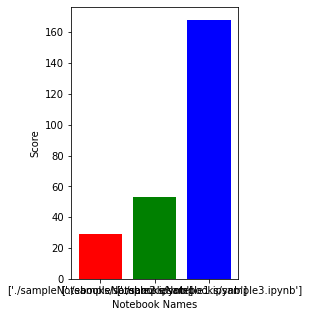

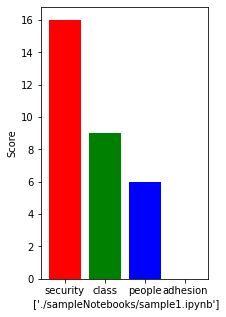

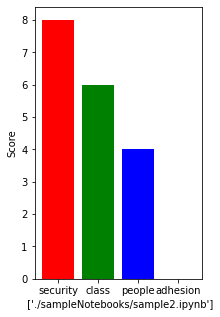

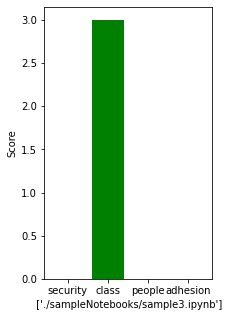

In [7]:
orderedResults = { nb:score for nb,score in sorted(totals.items(), key=lambda item:item[1])}
df = pd.DataFrame.from_dict(orderedResults, orient='index', columns=[('Total Score')])
print(df)
#PLot examples
f = plt.figure()
f.set_figwidth(3)
f.set_figheight(5)
plt.bar(range(len(orderedResults)),list(orderedResults.values()),align='center',color=['r','g','b'])
plt.xticks(range(len(orderedResults)),list(orderedResults.keys()))
plt.xlabel('Notebook Names')
plt.ylabel('Score')
plt.show

print('Regex patterns Found by notebook')
for result in notebookResults:
    terms = ast.literal_eval(notebookResults[result]['overallPatternCount'])
    terms = pd.DataFrame.from_dict(terms, orient='index', columns=[(result)])
    print(terms)

print('Terms Found by notebook')
for result in notebookResults:
    terms = ast.literal_eval(notebookResults[result]['overallTermCount'])
    g = plt.figure()
    g.set_figwidth(3)
    g.set_figheight(5)
    plt.bar(range(len(terms)),list(terms.values()),align='center',color=['r','g','b'])
    plt.xticks(range(len(terms)),list(terms.keys()))
    plt.xlabel(f" {result}")
    plt.ylabel('Score')
    plt.show



## Detailed Report <a id="Detailed Report"></a>

In [8]:
'''Save variables in the notebook checker function and then print them here.'''

'Save variables in the notebook checker function and then print them here.'